The data provided by Kaggle exists in several different files. We take a look at the data to understand it further to help us with modeling and feature generation. 

In [1]:
import numpy as np 
import pandas as pd 
import os
import gc 
import matplotlib.pyplot as plt
# import bokeh
%matplotlib inline
import seaborn as sns
p = sns.color_palette()

The training and testing data exists in two files clicks_train and clicks_test. They have two columns of data each -
* display_id - a set of recommendations given to a specific user
* ad_id - the specific ad

The training set also has the response column of whether the ad was clicked or not. 

In [2]:
df_train = pd.read_csv('clicks_train.csv')
df_test = pd.read_csv('clicks_test.csv')
df_train.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


In [8]:
print("no of rows in training set:", len(df_train))
print("no of rows in testing set:", len(df_test))

no of rows in training set: 87141731
no of rows in testing set: 32225162


In [19]:
# df_train['display_id'].value_counts
print("the number of displays in the training set is", len(df_train['display_id'].value_counts()))
print("the number of ads in the training set is", len(df_train['ad_id'].value_counts()))
print("the number of displays in the testing set is", len(df_test['display_id'].value_counts()))
print("the number of ads in the testing set is", len(df_test['ad_id'].value_counts()))

the number of displays in the training set is 16874593
the number of ads in the training set is 478950
the number of displays in the testing set is 6245533
the number of ads in the testing set is 381385


We have used some code from a kaggle script here to look at the data. Here we take a look at how many times each of the ads appear

Ads that appear less than 2 times: 22.69%
Ads that appear less than 10 times: 61.74%
Ads that appear less than 50 times: 86.93%
Ads that appear less than 100 times: 91.04%
Ads that appear less than 1000 times: 97.45%


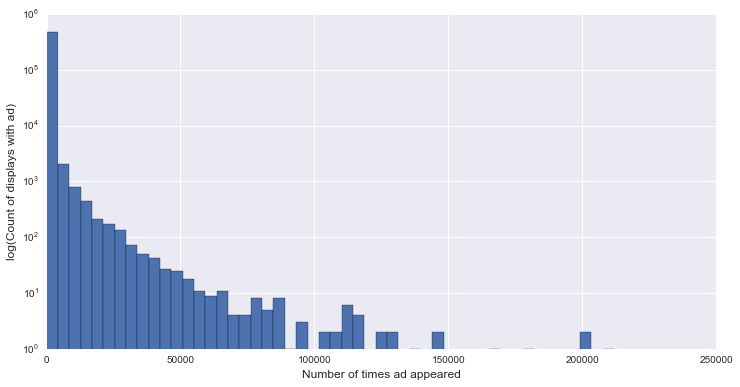

In [21]:
# https://www.kaggle.com/anokas/outbrain-click-prediction/outbrain-eda/comments
ad_usage_train = df_train.groupby('ad_id')['ad_id'].count()

for i in [2, 10, 50, 100, 1000]:
    print('Ads that appear less than {} times: {}%'.format(i, round((ad_usage_train < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(ad_usage_train.values, bins=50, log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)
plt.show()

A lot of the ads appear very few times. This indicates that we may have to use clustering to predict the clickthrough rate, especially for the ads which appear fewer times. 

In [3]:
del df_test
del df_train
gc.collect()

18

The events file looks at the users who clicked on the ads. The timestamp is relevant to the first click in the dataset. Platform and location are also provided. 

In [4]:
df_events = pd.read_csv('events.csv')
df_events.head()

/home/shoili/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


In [25]:
plat = df_events.platform.value_counts()

print(plat)
print('\nUnique values of platform:', df_events.platform.unique())

2     10684579
1      8747280
3      3032907
2       291699
1       279988
3        83668
\N           5
Name: platform, dtype: int64

Unique values of platform: [3 2 1 '2' '1' '3' '\\N']


We see that the values of platform (tablet, pc or phone) exist as both floats and strings so some cleaning may be needed. 

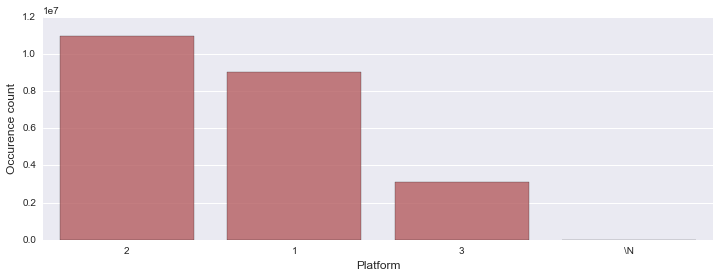

In [30]:
df_events.platform = df_events.platform.astype(str)
plat = df_events.platform.value_counts()

plt.figure(figsize=(12,4))
sns.barplot(plat.index, plat.values, alpha=0.8, color=p[2])
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Occurence count', fontsize=12)

We can see that we have data points from all devices

In [5]:
del df_events
gc.collect()

The dataset also provides a grouping of the documents based on topics. 

In [10]:
topics = pd.read_csv('documents_topics.csv')
len(topics)

11325960

Number of topics that appear more than 10000 times: 201
Number of topics that appear more than 50000 times: 86
Number of topics that appear more than 100000 times: 22
Number of topics that appear more than 200000 times: 3


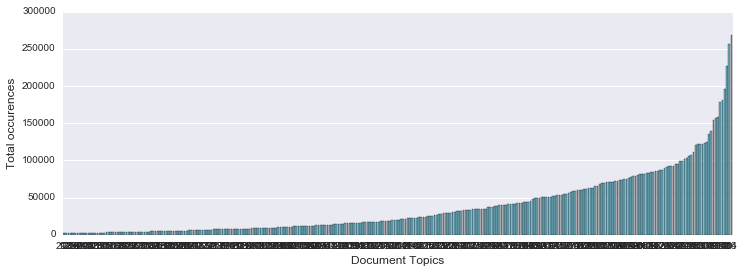

In [14]:
topic_ids = topics.groupby('topic_id')['confidence_level'].count().sort_values()

for i in [10000, 50000, 100000, 200000]:
    print('Number of topics that appear more than {} times: {}'
          .format(i, (topic_ids > i).sum()))

plt.figure(figsize=(12, 4))
sns.barplot(topic_ids.index, topic_ids.values, order=topic_ids.index, alpha=1, color=p[5])
plt.xlabel('Document Topics', fontsize=12)
plt.ylabel('Total occurences', fontsize=12)
plt.show()

In [15]:
del topics
del topic_ids
gc.collect()

116866

In [20]:
documents_meta = pd.read_csv('documents_meta.csv')
print(len(documents_meta))
documents_meta.head()

2999334


,document_id,source_id,publisher_id,publish_time
0,1595802,1.0,603.0,2016-06-05 00:00:00
1,1524246,1.0,603.0,2016-05-26 11:00:00
2,1617787,1.0,603.0,2016-05-27 00:00:00
3,1615583,1.0,603.0,2016-06-07 00:00:00
4,1615460,1.0,603.0,2016-06-20 00:00:00


This file contains data about the publisher and time the ad was published. We can try to use these are features for training the neural network. 

In [21]:
del documents_meta
gc.collect()

219

The page views file has information about the actual clicks. The file is 100GB uncompressed so we take a look at a sample subset here. 

In [23]:
page_views = pd.read_csv('page_views_sample.csv')
page_views.head()

,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1
3,8205775c5387f9,120,44196592,1,IN>16,2
4,9cb0ccd8458371,120,65817371,1,US>CA>807,2
